In [1]:
import os
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]
import numpy as np

import preprocessing

In [2]:
def float_or_nan(x):
    try:
        return float(x)
    except:
        return float('nan')

In [3]:
# Adapted from https://stackoverflow.com/a/44971987
import re

def plot_2d_acc(table_shape, pos_to_acc:dict, number_format="percent"):
    matrix = np.zeros(table_shape) * float('nan')
    
    for key in pos_to_acc:
        try:
            matcher = re.compile(r'2d_([0-9]+)\...._([0-9]+)\....')  # e.g. '2d_10.000_0.000'
            m = matcher.match(key)
            matrix[int(m.group(1)), int(m.group(2))] = pos_to_acc[key]
        except Exception as e:
            print(f"Error {e} for {key}")

    # plot the matrix as an image with an appropriate colormap
    fig = plt.figure()
    plt.imshow(matrix, aspect='equal', cmap="plasma", origin='lower')
    plt.xlabel("cm")
    plt.ylabel("cm")

    # add the values
    for (i, j), value in np.ndenumerate(matrix):
        if number_format == "percent":
            text = f"{value*100.:.0f}"
        else:
            text = f"{value:.1E}"
        plt.text(j, i, text, va='center', ha='center')
    
    plt.savefig("2d_tmptmp.svg")
    plt.show()
    return matrix

# rev1

In [4]:
table_shape = (11,11)

paths = [
    './result_files/test_accuracy_20220701-1439.json',
    "./result_files/test_accuracy_20220703-1454.json",
    "./result_files/test_accuracy_20220703-1312.json",
]

key = "test_accuracies"


with open(os.path.join(paths[0]), 'r') as file:
    dict_accuracies = json.load(file)[key]
    
for path in paths[1:]:
    with open(path, 'r') as file:
         dict_accuracies.update(json.load(file)[key])

for key in dict_accuracies:
    dict_accuracies[key] = float(np.max(dict_accuracies[key]))
print(dict_accuracies)

{'2d_0.000_0.000': 0.3012458097763546, '2d_0.000_1.000': 0.24801120728473508, '2d_0.000_2.000': 0.24801120728473508, '2d_0.000_3.000': 0.2479111422424576, '2d_0.000_4.000': 0.2552659228498524, '2d_0.000_5.000': 0.38840246160004005, '2d_0.000_6.000': 0.38099764847150647, '2d_0.000_7.000': 0.35968379446640314, '2d_0.000_8.000': 0.3402211437434332, '2d_0.000_9.000': 0.3510281683094011, '2d_0.000_10.000': 0.3484264772101866, '2d_1.000_0.000': 0.24801120728473508, '2d_1.000_1.000': 0.3099014359333567, '2d_1.000_2.000': 0.2552659228498524, '2d_1.000_3.000': 0.36898984339820884, '2d_1.000_4.000': 0.4169209986491219, '2d_1.000_5.000': 0.4613498774203232, '2d_1.000_6.000': 0.4579476659828889, '2d_1.000_7.000': 0.42170302181308783, '2d_1.000_8.000': 0.3751438434982739, '2d_1.000_9.000': 0.4061640066042928, '2d_1.000_10.000': 0.37339270525841795, '2d_2.000_0.000': 0.3433231600540351, '2d_2.000_1.000': 0.33796968029218993, '2d_2.000_2.000': 0.24801120728473508, '2d_2.000_3.000': 0.3983089007855105

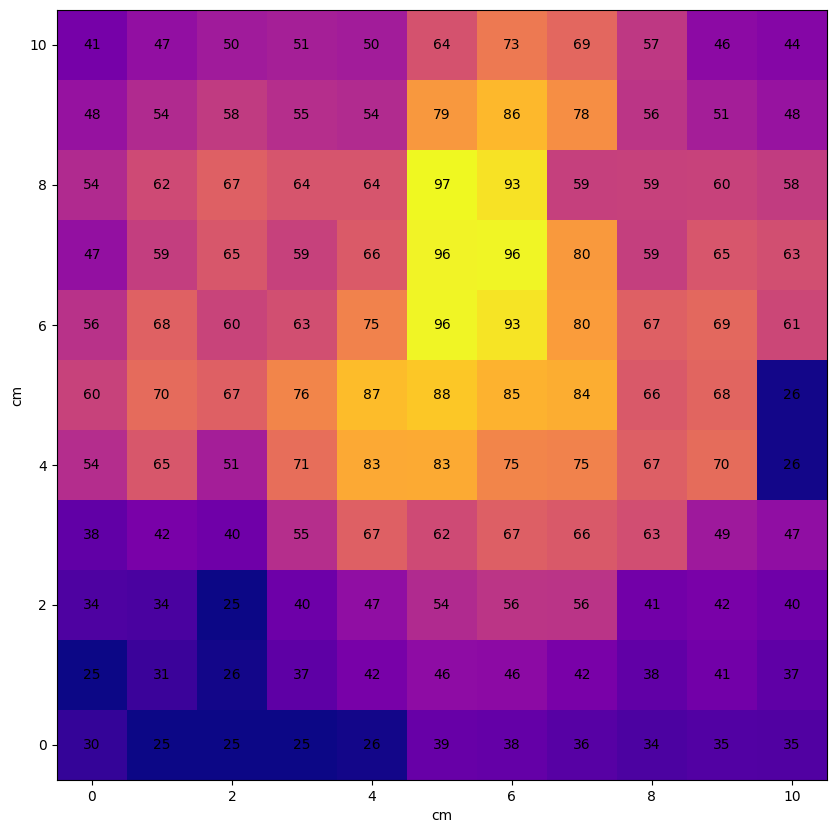

In [5]:
matrix = plot_2d_acc(table_shape, dict_accuracies)

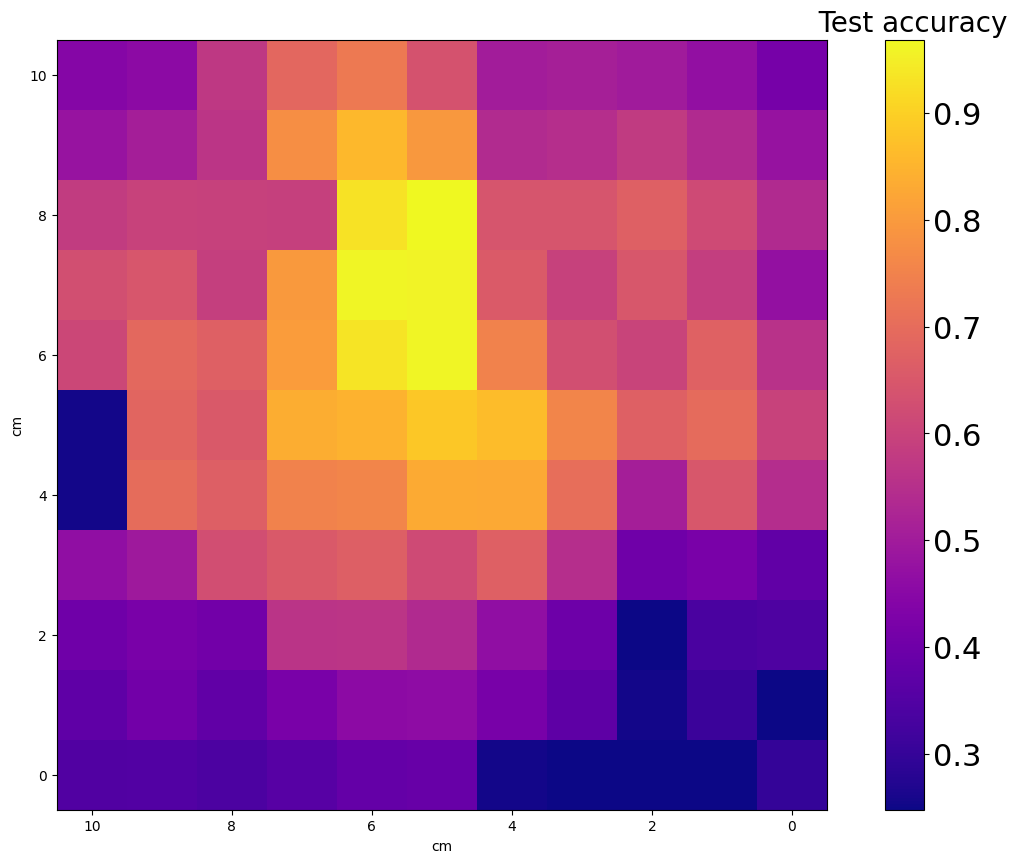

In [6]:
fig, ax = plt.subplots()
imsh = ax.imshow(matrix, cmap='plasma', origin='lower')
ax.invert_xaxis()

cbar = fig.colorbar(imsh, ax=ax)
cbar.ax.tick_params(labelsize=22)
cbar.ax.set_title("  Test accuracy", fontsize=20)

ax.set_xlabel("cm")
ax.set_ylabel("cm")

plt.savefig("2d_test_acc_rev1.svg")
plt.show()

In [7]:
def get_avg_intensity(measurement_folder):
    filenames = [filename for filename in os.listdir(measurement_folder)
                 if os.path.isfile(os.path.join(measurement_folder, filename))]
    
    pattern_data = re.compile("(.*)_data_numpy.npy")
    filename_data = [pattern_data.match(i)[0] for i in filenames if pattern_data.match(i) is not None]
    pattern_synch = re.compile("(.*)_synch_debug_signal_numpy.npy")
    filename_synch = [pattern_synch.match(i)[0] for i in filenames if pattern_synch.match(i) is not None]

    filename_data.sort(key=preprocessing.natural_keys)
    filename_synch.sort(key=preprocessing.natural_keys)
    print(filename_data)


    offset_header_rev1 = -200
    offset_header_rev2 = 200
    if "rev1" in measurement_folder.lower():
        offset_header = offset_header_rev1
    elif "rev2" in measurement_folder.lower():
        offset_header = offset_header_rev2
    else:
        raise NotImplementedError("Specify which offset should be used!")
    technical_details = {
        "header_length": 1,  # Number of symbols used to identify the header
        "clock_freq": int(100e6),  # Clock frequency (Hz) of the sender electronics
        "sample_freq": int(1e10),  # Sample frequency (Hz) used by oscilloscope
        "signal_length": 2_000_002,  # Total number of data points of one measurement
        "steps_to_left": 2,  # start for the cut position in symbols to the left from the header position
        "steps_to_right": 3,  # end for the cut position in symbols to the right from the header position
        "do_normalize_data": False,  # Use if data should be normalized to have zero mean and std 1
    }
    
    averages = {}

    for dataname, synchname in zip(filename_data, filename_synch):
        measured_signal, _, _ = preprocessing.load_data_synchronized(
                    folder_path=measurement_folder,
                    file_path=os.path.join(measurement_folder, dataname, ),
                    file_path_synch=os.path.join(measurement_folder, synchname, ),
                    clock_freq=technical_details["clock_freq"],
                    sample_freq=technical_details["sample_freq"],
                    signal_length=technical_details["signal_length"],
                    offset_header=offset_header,
                    do_normalize_data=technical_details["do_normalize_data"],
                    prefix="training",
                    debug=False,
                )
        
        averages[dataname] = np.average(np.abs(measured_signal)**2)
        
    return averages

In [8]:
def get_all_intensity_averages(dataset_folder):
    all_averages = {}

    measurement_folders = [filename for filename in os.listdir(dataset_folder)
                     if os.path.isdir(os.path.join(dataset_folder, filename))]

    for measurement_folder in measurement_folders:
        measurement_folder = os.path.join(dataset_folder, measurement_folder)
        all_averages[measurement_folder] = get_avg_intensity(measurement_folder)

    return all_averages

In [9]:
with open(os.path.join("./result_files/Rev1_intensities.json"), 'r') as file:
    intensities_rev1 = json.load(file)

0.0013579914101632343


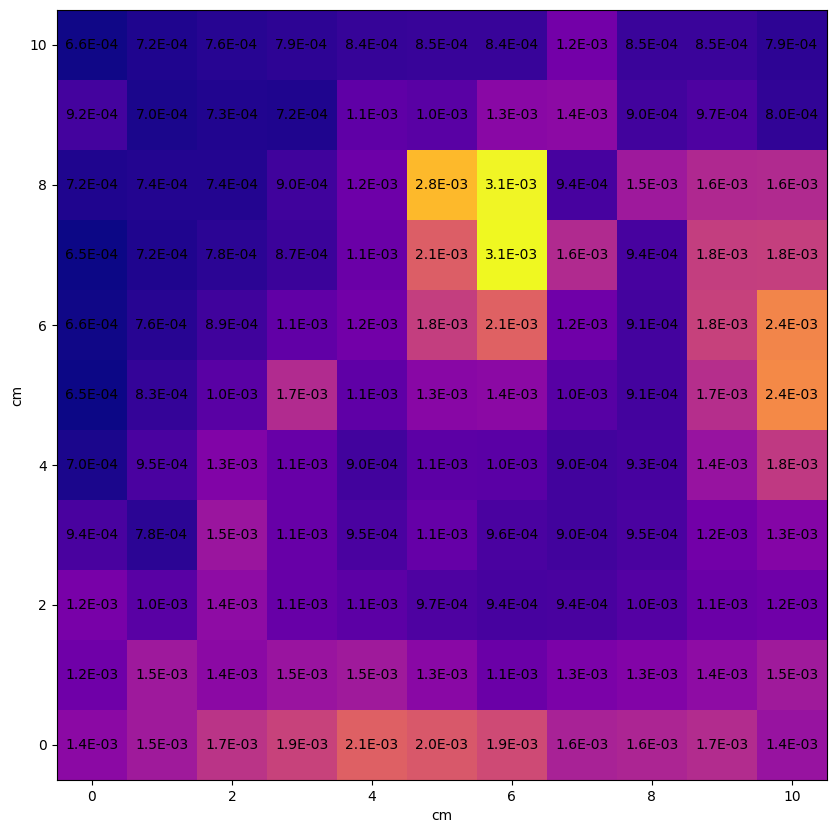

In [10]:
rms_amplitudes_rev1 = {}
for key in intensities_rev1:
    rms_amplitudes_rev1[os.path.basename(key)] = np.sqrt(np.average(list(intensities_rev1[key].values())))
    
print(rms_amplitudes_rev1["2d_0.000_0.000"])
matrix_rms_rev1 = plot_2d_acc(table_shape, rms_amplitudes_rev1, number_format=None)

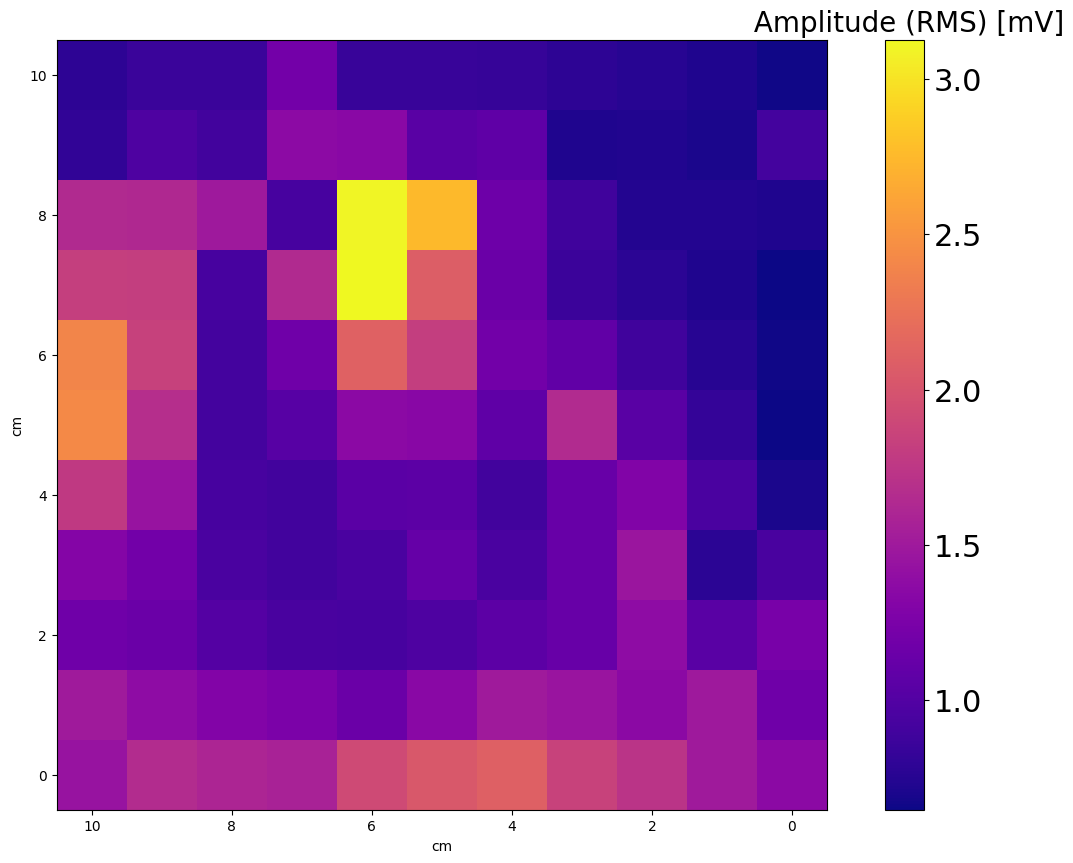

In [11]:
fig, ax = plt.subplots()
imsh = ax.imshow(matrix_rms_rev1 * 1000, cmap='plasma', origin='lower')
ax.invert_xaxis()

cbar = fig.colorbar(imsh, ax=ax)
cbar.ax.tick_params(labelsize=22)
cbar.ax.set_title(" Amplitude (RMS) [mV]", fontsize=20)

ax.set_xlabel("cm")
ax.set_ylabel("cm")

plt.savefig("2d_rms_rev1.svg")
plt.show()

# rev2

In [12]:
table_shape = (11,11)

paths = [
    './result_files/test_accuracy_20220627-0936.json',
    './result_files/test_accuracy_20220627-1656.json',
    './result_files/test_accuracy_20220628-1059.json',
    './result_files/result_TEMPEST_20220815-1354.json',
]

key = "test_accuracies"


with open(os.path.join(paths[0]), 'r') as file:
    dict_accuracies_rev2 = json.load(file)[key]
    
for path in paths[1:]:
    with open(path, 'r') as file:
         dict_accuracies_rev2.update(json.load(file)[key])

for key in dict_accuracies_rev2:
    dict_accuracies_rev2[key] = float(np.max(dict_accuracies_rev2[key]))
print(dict_accuracies_rev2)

{'2d_0.000_0.000': 0.3893530795016761, '2d_0.000_1.000': 0.4780607394806624, '2d_0.000_2.000': 0.5012758292890379, '2d_0.000_3.000': 0.44333816981037677, '2d_0.000_4.000': 0.3935057787561915, '2d_0.000_5.000': 0.3732926402161405, '2d_0.000_6.000': 0.34012107870115577, '2d_0.000_7.000': 0.29594236253564815, '2d_0.000_8.000': 0.24796117476359633, '2d_0.000_9.000': 0.2552659228498524, '2d_0.000_10.000': 0.2552659228498524, '2d_1.000_0.000': 0.36203532295992397, '2d_1.000_1.000': 0.42927903137039075, '2d_1.000_2.000': 0.3986591284334818, '2d_1.000_3.000': 0.44133686896482716, '2d_1.000_4.000': 0.45279431630559863, '2d_1.000_5.000': 0.4061640066042928, '2d_1.000_6.000': 0.3908540551358383, '2d_1.000_7.000': 0.3430229649272027, '2d_1.000_8.000': 0.31984190514308586, '2d_1.000_9.000': 0.2552659228498524, '2d_1.000_10.000': 0.2552659228498524, '2d_2.000_0.000': 0.41622054335317954, '2d_2.000_1.000': 0.48956821934257266, '2d_2.000_2.000': 0.5766748386451194, '2d_2.000_3.000': 0.6032421073697903

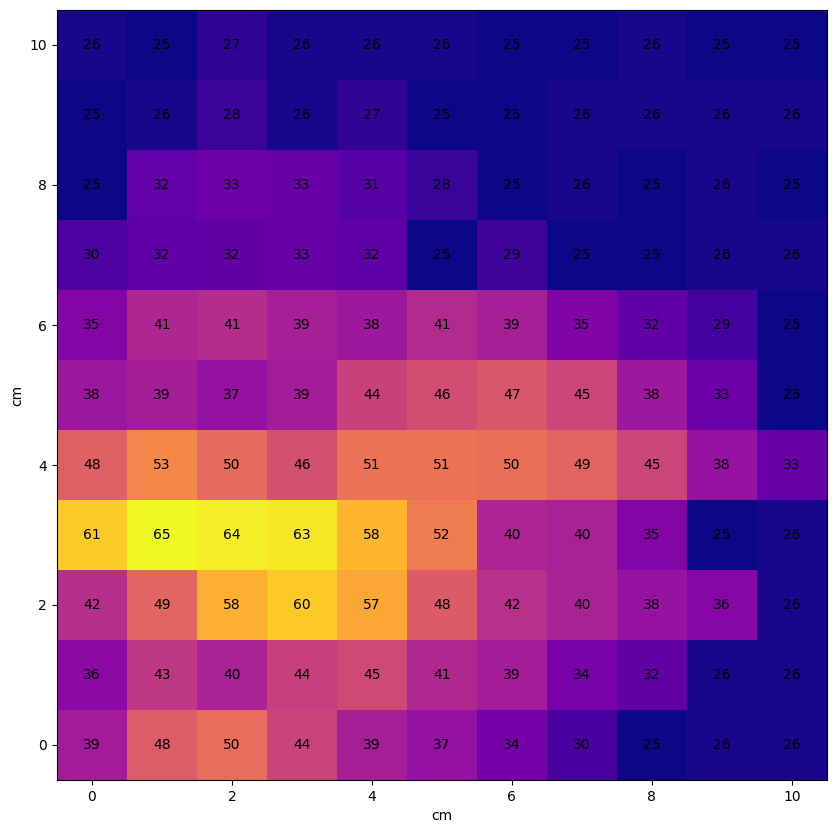

In [13]:
matrixrev2 = plot_2d_acc(table_shape, dict_accuracies_rev2)

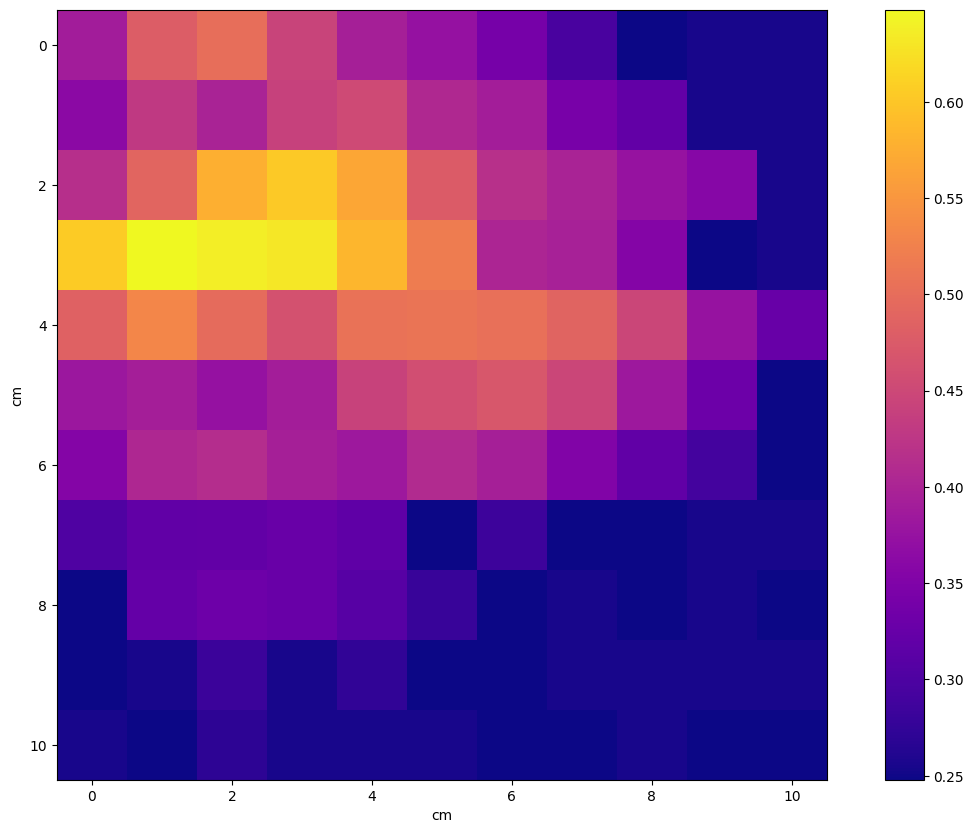

In [14]:
fig, ax = plt.subplots()

# note: origin of rev2 2d dataset is specified in the metadata as "0,0 is at corner closest to FPGA. 0,1 is one step towards optics package"
imsh = ax.imshow(matrixrev2, cmap='plasma',)

fig.colorbar(imsh, ax=ax)
ax.set_xlabel("cm")
ax.set_ylabel("cm")

plt.savefig("2d_test_acc_rev2.svg")
plt.show()

In [15]:
with open("./result_files/Rev22D_intensities.json", 'r') as file:
    intensities_rev2 = json.load(file)
    
with open("./result_files/Rev22Dstart_7_0_intensities.json", 'r') as file:
     intensities_rev2.update(json.load(file))

In [16]:
print(intensities_rev2["/project/ag-weinfurter/crypto/PhDs/Adomas/EmissionSecurityMeasuredData/DataForEmSecPaper/Rev22D/2d_0.000_0.000"])

{'test_0_data_numpy.npy': 3.210216292171178e-07, 'test_1_data_numpy.npy': 3.1863507169584976e-07, 'test_2_data_numpy.npy': 3.88021890738808e-07, 'train_0_data_numpy.npy': 3.385072993089964e-07, 'train_1_data_numpy.npy': 5.018795701774498e-07, 'train_2_data_numpy.npy': 3.4396453134184576e-07, 'train_3_data_numpy.npy': 3.368698989063705e-07, 'train_4_data_numpy.npy': 3.370112117358406e-07, 'train_5_data_numpy.npy': 4.825953535060664e-07, 'train_6_data_numpy.npy': 3.406628389900368e-07}


2d_10.000_8.000


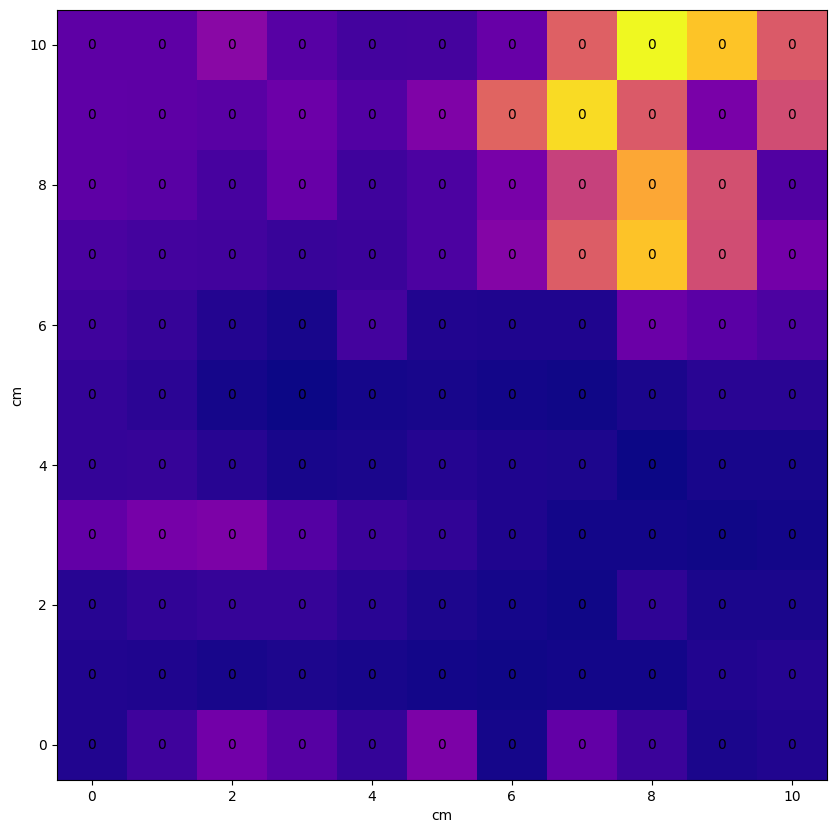

In [17]:
rms_amplitudes_rev2 = {}

for key in intensities_rev2:
    rms_amplitudes_rev2[os.path.basename(key)] = np.sqrt(np.average(list(intensities_rev2[key].values())))

print(max(rms_amplitudes_rev2, key=rms_amplitudes_rev2.get))
matrixrev2 = plot_2d_acc(table_shape, rms_amplitudes_rev2)

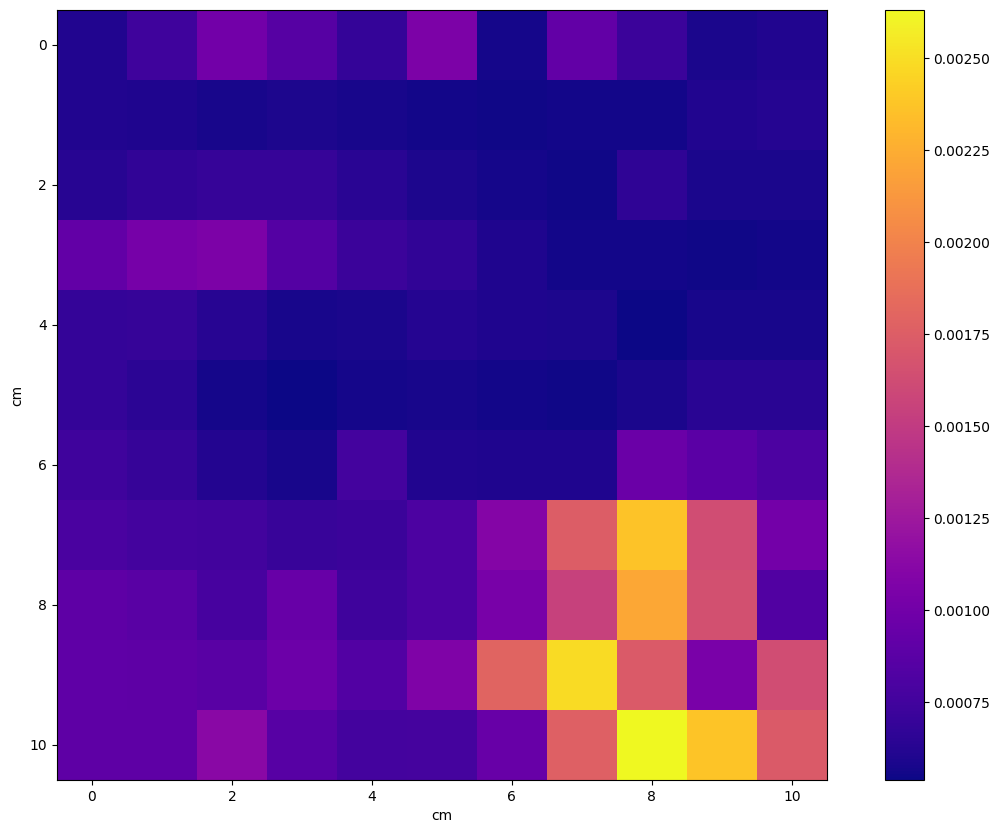

In [18]:
fig, ax = plt.subplots()

# note: origin of rev2 2d dataset is specified in the metadata as "0,0 is at corner closest to FPGA. 0,1 is one step towards optics package"
imsh = ax.imshow(matrixrev2, cmap='plasma',)

fig.colorbar(imsh, ax=ax)
ax.set_xlabel("cm")
ax.set_ylabel("cm")

plt.savefig("2d_rms_rev2.svg")
plt.show()